In [186]:
sentiment = pd.read_csv('../data/cleaned/unified_crypto_sentiment_2024_2025.csv', parse_dates=['timestamp'])
whales = pd.read_csv('../data/cleaned/whale_activity_2024_2025_sorted.csv', parse_dates=['time_range'])


In [187]:
#Step 1
import pandas as pd

# Load sentiment and whale data (correct paths!)
sentiment = pd.read_csv('../data/cleaned/unified_crypto_sentiment_2024_2025.csv', parse_dates=['timestamp'])
whales = pd.read_csv('../data/cleaned/whale_activity_2024_2025_sorted.csv', parse_dates=['time_range'])

# Preview
print(sentiment.columns)
print(whales.columns)



Index(['timestamp', 'coin', 'sentiment', 'polarity', 'source', 'text'], dtype='object')
Index(['coin', 'blockchain', 'time_range', 'whale_transaction_count',
       'total_volume'],
      dtype='object')


In [188]:
#A. Filter for Main Coins
main_coins = ['BTC', 'ETH', 'ADA', 'SOL']

# Filter both datasets to keep only main coins
sentiment = sentiment[sentiment['coin'].isin(main_coins)].copy()
whales = whales[whales['coin'].isin(main_coins)].copy()

In [189]:
#B. Aggregate to Daily per Coin
#Aggregate Sentiment
# Convert timestamp to date (if not already done)
sentiment['date'] = sentiment['timestamp'].dt.date

# Daily aggregation per coin
sentiment_daily = sentiment.groupby(['coin', 'date']).agg({
    'sentiment': 'mean',
    'polarity': lambda x: x.mode()[0] if not x.mode().empty else 'neutral'
}).reset_index()




In [190]:
#B. Aggregate to Daily per Coin
#Aggregate Whales Activity
# Convert time_range to date (if not already done)
whales['date'] = whales['time_range'].dt.date

# Daily aggregation per coin
whale_daily = whales.groupby(['coin', 'date']).agg({
    'whale_transaction_count': 'sum',
    'total_volume': 'sum'
}).reset_index()


In [191]:
#C. Merge the Datasets on coin and date
# Merge the daily sentiment and whale data
df = pd.merge(whale_daily, sentiment_daily, on=['coin', 'date'], how='inner')
df = df.sort_values(['coin', 'date'])



In [192]:
#1. Create Lagged Features (Previous Day’s Sentiment & Polarity)
# Lagged sentiment and polarity (previous day, per coin)
df['sentiment_lag1'] = df.groupby('coin')['sentiment'].shift(1)
df['polarity_lag1'] = df.groupby('coin')['polarity'].shift(1)



In [ ]:
!pip install scikit-learn




In [194]:
#2. Encode Polarity (to Numbers) / Polarity I have is (positive, neutral,negative)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['polarity_lag1_enc'] = le.fit_transform(df['polarity_lag1'])

In [195]:
#3. Drop Missing Rows
df = df.dropna()


In [196]:
#4. Split Data into Train and Test Sets (by Date)
# Make sure date is datetime (for proper comparison)
df['date'] = pd.to_datetime(df['date'])

train = df[df['date'] < pd.to_datetime('2025-03-01')]
test = df[df['date'] >= pd.to_datetime('2025-03-01')]



In [197]:
#5. Set Features and Target
features = ['sentiment_lag1', 'polarity_lag1_enc']
target = 'whale_transaction_count'


In [198]:
print(df.head())
print(train.shape, test.shape)

  coin       date  whale_transaction_count  total_volume  sentiment  polarity  \
1  ADA 2024-01-03                      112      27229.17   0.932500  positive   
2  ADA 2024-01-04                      112      24663.17   0.886000  positive   
3  ADA 2024-01-06                       59      15799.08   0.704067  positive   
4  ADA 2024-01-08                       74      16836.76   0.612400  positive   
5  ADA 2024-01-10                       98      19005.92   0.318200  positive   

   sentiment_lag1 polarity_lag1  polarity_lag1_enc  
1        0.354800       neutral                  1  
2        0.932500      positive                  2  
3        0.886000      positive                  2  
4        0.704067      positive                  2  
5        0.612400      positive                  2  
(1142, 9) (539, 9)


Linear Regression Results:
  RMSE: 132.87927011413726
  R^2: -0.0018649327932260817


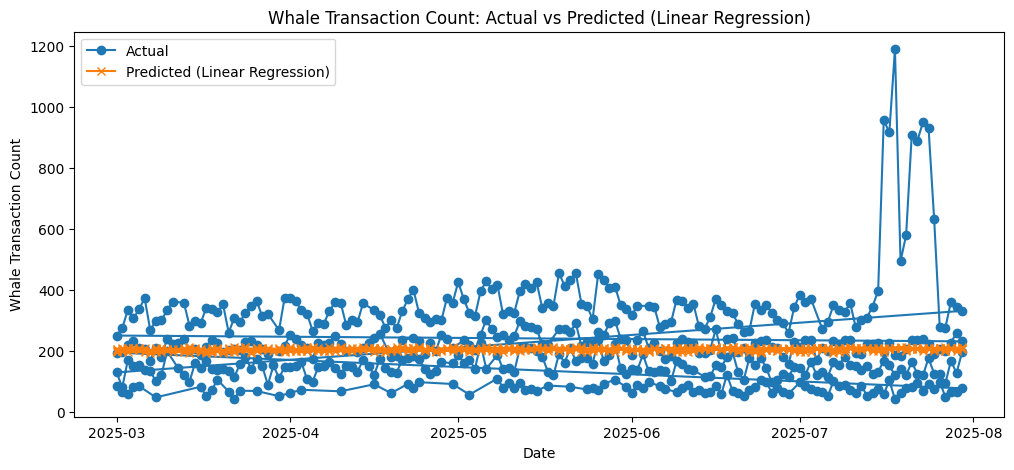

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Initialize the model
lr = LinearRegression()

# 2. Train the model on your training data
lr.fit(train[features], train[target])

# 3. Predict on your test data
pred_lr = lr.predict(test[features])

# 4. Evaluate the model
# RMSE: take square root of MSE manually
rmse_lr = np.sqrt(mean_squared_error(test[target], pred_lr))
r2_lr = r2_score(test[target], pred_lr)

print("Linear Regression Results:")
print("  RMSE:", rmse_lr)
print("  R^2:", r2_lr)

# 5. (Optional) Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test['date'], test[target], label='Actual', marker='o')
plt.plot(test['date'], pred_lr, label='Predicted (Linear Regression)', marker='x')
plt.legend()
plt.title('Whale Transaction Count: Actual vs Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Whale Transaction Count')
plt.show()


Random Forest Results:
  RMSE: 143.15016836279483
  R^2: -0.1627288116859702


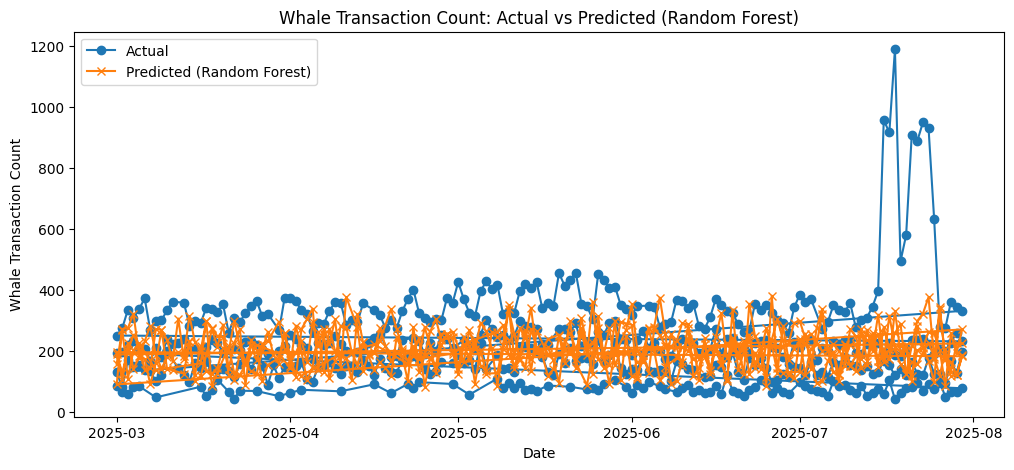

In [200]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train[features], train[target])
pred_rf = rf.predict(test[features])

rmse_rf = np.sqrt(mean_squared_error(test[target], pred_rf))
r2_rf = r2_score(test[target], pred_rf)

print("Random Forest Results:")
print("  RMSE:", rmse_rf)
print("  R^2:", r2_rf)

# Plot
plt.figure(figsize=(12,5))
plt.plot(test['date'], test[target], label='Actual', marker='o')
plt.plot(test['date'], pred_rf, label='Predicted (Random Forest)', marker='x')
plt.legend()
plt.title('Whale Transaction Count: Actual vs Predicted (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Whale Transaction Count')
plt.show()


In [201]:
# Horrible Results

In [202]:
# A way to improve the model (below 8):
# Add previous day's whale transaction count (per coin)
df = df.sort_values(['coin', 'date'])
df['whale_tx_lag1'] = df.groupby('coin')['whale_transaction_count'].shift(1)

# Already have:
# df['sentiment_lag1'], df['polarity_lag1']

# Optional: Rolling mean of whale tx over the last 3 days (shifted to not include today)
df['whale_tx_roll3'] = (
    df.groupby('coin')['whale_transaction_count']
    .rolling(window=3).mean()
    .shift(1)
    .reset_index(level=0, drop=True)
)


In [203]:
# This will add columns: coin_ADA, coin_BTC, coin_ETH, coin_SOL
df = pd.get_dummies(df, columns=['coin'])


In [204]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['polarity_lag1_enc'] = le.fit_transform(df['polarity_lag1'])


In [205]:
df = df.dropna()


In [206]:
df['date'] = pd.to_datetime(df['date'])

# Train: dates before 2025-01-01
train = df[df['date'] < pd.to_datetime('2025-01-01')]

# Test: dates from 2025-01-01 (edit if you want better results, end of test is July)
test = df[(df['date'] >= pd.to_datetime('2025-01-01'))]


In [207]:
features = [
    'sentiment_lag1',
    'polarity_lag1_enc',
    'whale_tx_lag1',
    'whale_tx_roll3',
    'coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL'
]
target = 'whale_transaction_count'


In [208]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train[features], train[target])
pred_rf = rf.predict(test[features])

rmse_rf = np.sqrt(mean_squared_error(test[target], pred_rf))
r2_rf = r2_score(test[target], pred_rf)

print("Random Forest Results:")
print("  RMSE:", rmse_rf)
print("  R^2:", r2_rf)


Random Forest Results:
  RMSE: 65.10853713804096
  R^2: 0.7286731315911783


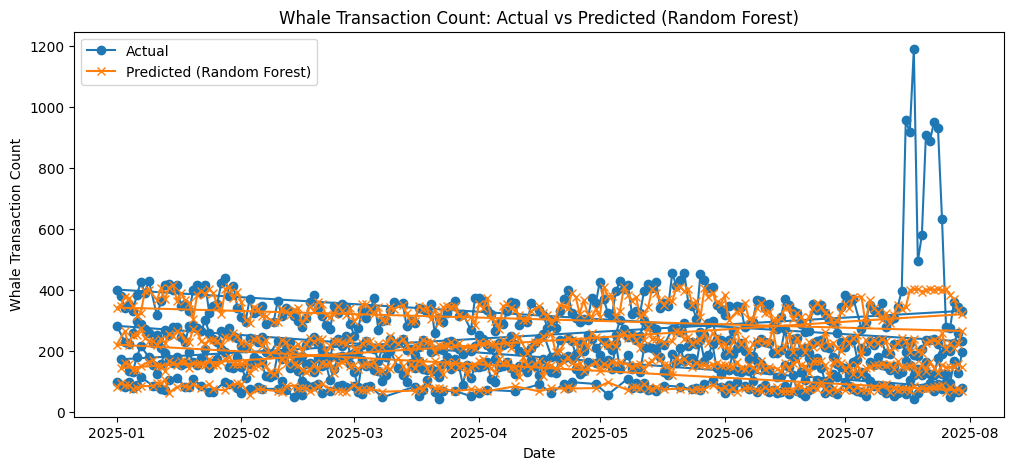

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test['date'], test[target], label='Actual', marker='o')
plt.plot(test['date'], pred_rf, label='Predicted (Random Forest)', marker='x')
plt.legend()
plt.title('Whale Transaction Count: Actual vs Predicted (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Whale Transaction Count')
plt.show()

Improved Linear Regression Results:
  RMSE: 65.10853713804096
  R^2: 0.8136907307899841


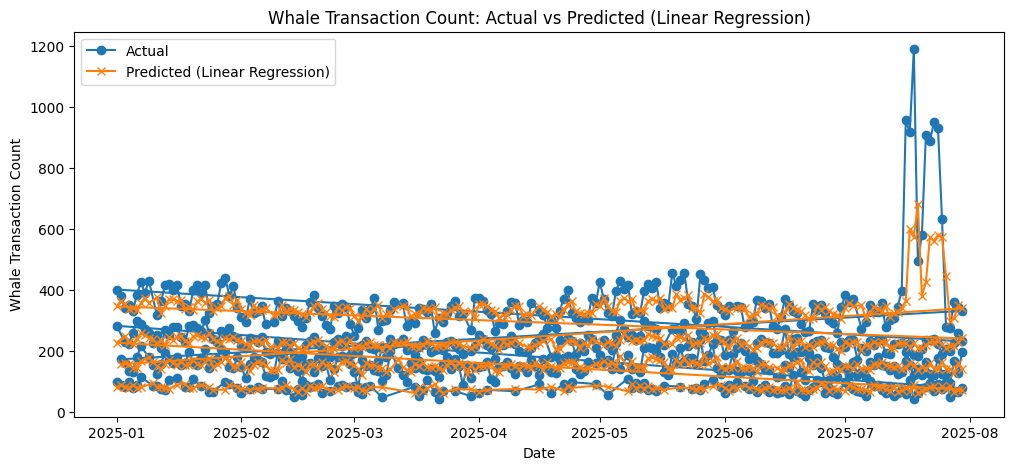

In [210]:
# A way to improve the Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Use the same features as before
features = [
    'sentiment_lag1',
    'polarity_lag1_enc',
    'whale_tx_lag1',
    'whale_tx_roll3',
    'coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL'
]
target = 'whale_transaction_count'

# Standardize features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_test_scaled = scaler.transform(test[features])

# Train the linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, train[target])

# Predict on test data
pred_lr = lr.predict(X_test_scaled)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(test[target], pred_lr))
r2_lr = r2_score(test[target], pred_lr)

print("Improved Linear Regression Results:")
print("  RMSE:", rmse_rf)
print("  R^2:", r2_lr)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test['date'], test[target], label='Actual', marker='o')
plt.plot(test['date'], pred_lr, label='Predicted (Linear Regression)', marker='x')
plt.legend()
plt.title('Whale Transaction Count: Actual vs Predicted (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Whale Transaction Count')
plt.show()


\[
\begin{aligned}
\text{Whale\_Activity} =\ & 201.094 \\
 & + 1.076 \times \text{sentiment\_lag1} \\
 & - 0.295 \times \text{polarity\_lag1\_enc} \\
 & + 44.791 \times \text{whale\_tx\_lag1} \\
 & - 4.580 \times \text{whale\_tx\_roll3} \\
 & - 32.307 \times \text{coin\_ADA} \\
 & + 6.996 \times \text{coin\_BTC} \\
 & + 36.145 \times \text{coin\_ETH} \\
 & - 11.885 \times \text{coin\_SOL}
\end{aligned}
\]


In [ ]:
#XGBoost Model
!pip install xgboost

In [212]:
#Step A: Features (Same as improved model):
features = [
    'sentiment_lag1',
    'polarity_lag1_enc',
    'whale_tx_lag1',
    'whale_tx_roll3',
    'coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL'
]
target = 'whale_transaction_count'


In [213]:
#Step B: Standardize Features (Recommended for XGBoost)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[features])
X_test_scaled = scaler.transform(test[features])


In [214]:
# Step C: Train XGBoost Regressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train model
xgb_model.fit(X_train_scaled, train[target])

# Make predictions
pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate model
rmse_xgb = np.sqrt(mean_squared_error(test[target], pred_xgb))
r2_xgb = r2_score(test[target], pred_xgb)

print("XGBoost Regression Results:")
print("  RMSE:", rmse_xgb)
print("  R^2:", r2_xgb)


XGBoost Regression Results:
  RMSE: 61.96301741638919
  R^2: 0.7542564868927002


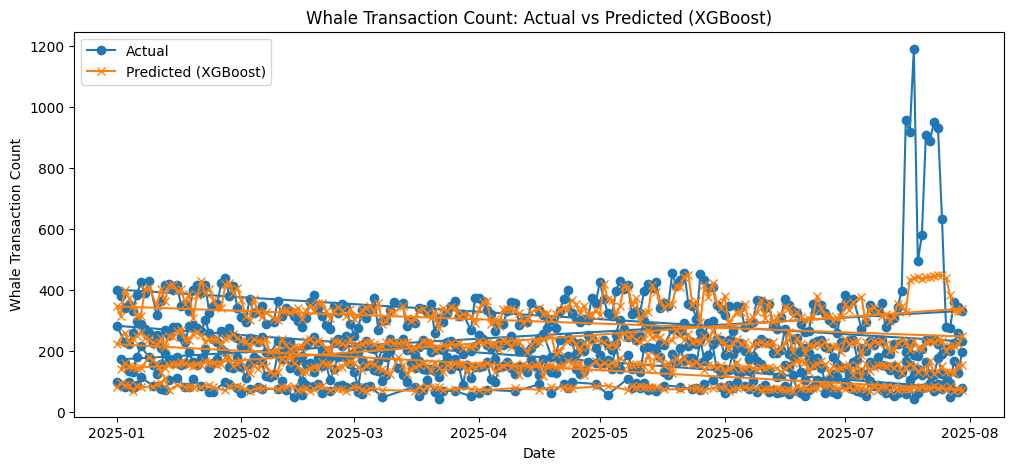

In [215]:
#Step D: Plotting Predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test['date'], test[target], label='Actual', marker='o')
plt.plot(test['date'], pred_xgb, label='Predicted (XGBoost)', marker='x')
plt.legend()
plt.title('Whale Transaction Count: Actual vs Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Whale Transaction Count')
plt.show()


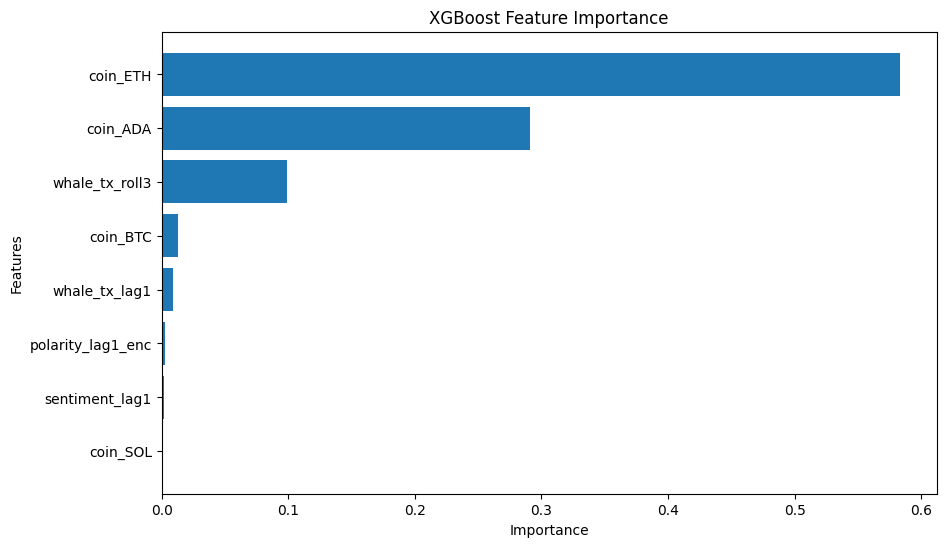

In [216]:
#XGBoost Features Importance
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importance
importance = xgb_model.feature_importances_

# Put into a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=True)

# Plot the feature importance clearly with feature names
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [ ]:
#1. Linear Regression Model Equation
# features = [...] (your list of features)
print("Linear Regression Equation:")
print(f"Whale_Activity = {lr.intercept_:.3f}", end='')

for coef, feat in zip(lr.coef_, features):
    print(f" + ({coef:.3f} * {feat})", end='')
print()


Linear Regression Equation:
Whale_Activity = 201.094 + (1.076 * sentiment_lag1) + (-0.295 * polarity_lag1_enc) + (44.791 * whale_tx_lag1) + (-4.580 * whale_tx_roll3) + (-32.307 * coin_ADA) + (6.996 * coin_BTC) + (36.145 * coin_ETH) + (-11.885 * coin_SOL)


In [ ]:
""" 
Whale_Activity = 201.094 + (1.076 * sentiment_lag1) + (-0.295 * polarity_lag1_enc) + (44.791 * whale_tx_lag1) + 
(-4.580 * whale_tx_roll3) + (-32.307 * coin_ADA) + (6.996 * coin_BTC) + (36.145 * coin_ETH) + (-11.885 * coin_SOL)
"""

In [218]:
# Linear Regression equation
print("Linear Regression Equation:")
eqn = f"Whale_Activity = {lr.intercept_:.3f}"
for coef, feat in zip(lr.coef_, features):
    eqn += f" + ({coef:.3f} * {feat})"
print(eqn)

# Random Forest feature importances
print("\nRandom Forest Feature Importances:")
for feat, imp in zip(features, rf.feature_importances_):
    print(f"{feat}: {imp:.3f}")

# XGBoost feature importances
print("\nXGBoost Feature Importances:")
for feat, imp in zip(features, xgb_model.feature_importances_):
    print(f"{feat}: {imp:.3f}")


Linear Regression Equation:
Whale_Activity = 201.094 + (1.076 * sentiment_lag1) + (-0.295 * polarity_lag1_enc) + (44.791 * whale_tx_lag1) + (-4.580 * whale_tx_roll3) + (-32.307 * coin_ADA) + (6.996 * coin_BTC) + (36.145 * coin_ETH) + (-11.885 * coin_SOL)

Random Forest Feature Importances:
sentiment_lag1: 0.023
polarity_lag1_enc: 0.003
whale_tx_lag1: 0.140
whale_tx_roll3: 0.632
coin_ADA: 0.044
coin_BTC: 0.006
coin_ETH: 0.147
coin_SOL: 0.006

XGBoost Feature Importances:
sentiment_lag1: 0.002
polarity_lag1_enc: 0.002
whale_tx_lag1: 0.009
whale_tx_roll3: 0.099
coin_ADA: 0.291
coin_BTC: 0.013
coin_ETH: 0.583
coin_SOL: 0.001


In [219]:
# For Random Forest
for feat, imp in zip(features, rf.feature_importances_):
    print(f"{feat}: {imp:.3f}")

# For XGBoost
for feat, imp in zip(features, xgb_model.feature_importances_):
    print(f"{feat}: {imp:.3f}")

sentiment_lag1: 0.023
polarity_lag1_enc: 0.003
whale_tx_lag1: 0.140
whale_tx_roll3: 0.632
coin_ADA: 0.044
coin_BTC: 0.006
coin_ETH: 0.147
coin_SOL: 0.006
sentiment_lag1: 0.002
polarity_lag1_enc: 0.002
whale_tx_lag1: 0.009
whale_tx_roll3: 0.099
coin_ADA: 0.291
coin_BTC: 0.013
coin_ETH: 0.583
coin_SOL: 0.001


In [221]:
print("Intercept:", lr.intercept_)
for feat, coef in zip(features, lr.coef_):
    print(f"{feat}: {coef}")


Intercept: 201.09368191721134
sentiment_lag1: 1.07578101080851
polarity_lag1_enc: -0.295357647506322
whale_tx_lag1: 44.7909763299023
whale_tx_roll3: -4.580026073829977
coin_ADA: -32.3066042650722
coin_BTC: 6.996108304788746
coin_ETH: 36.144774376472185
coin_SOL: -11.885491530285544


\[
\begin{aligned}
\text{Whale\_Activity} =\ & 201.09
    + 1.08 \times \text{sentiment\_lag1} \\
  & - 0.30 \times \text{polarity\_lag1\_enc} \\
  & + 44.79 \times \text{whale\_tx\_lag1} \\
  & - 4.58 \times \text{whale\_tx\_roll3} \\
  & - 32.31 \times \text{coin\_ADA} \\
  & + 6.99 \times \text{coin\_BTC} \\
  & + 36.14 \times \text{coin\_ETH} \\
  & - 11.89 \times \text{coin\_SOL}
\end{aligned}
\]


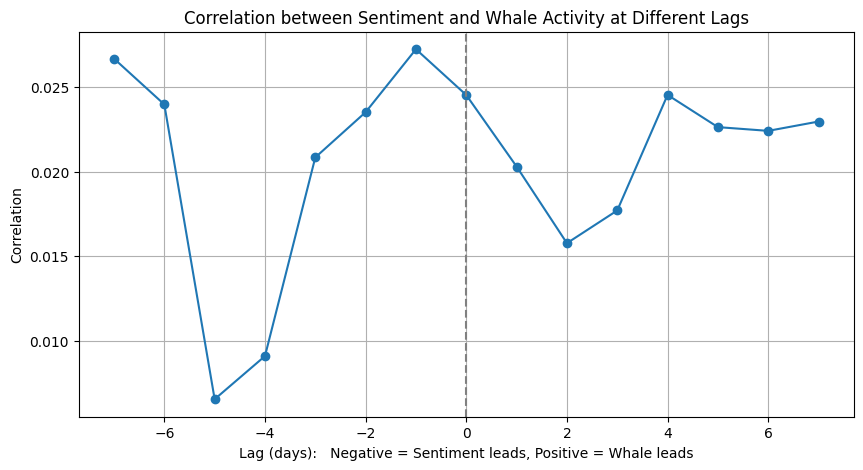

In [229]:
import numpy as np
import matplotlib.pyplot as plt

max_lag = 7  # test up to 7 days before/after
lags = range(-max_lag, max_lag+1)
corrs = []

for lag in lags:
    if lag < 0:
        shifted = df['sentiment'].shift(-lag)  # sentiment leads whale activity
    else:
        shifted = df['sentiment'].shift(-lag)  # whale leads sentiment (same, but you interpret lag sign)
    corr = df['whale_transaction_count'].corr(shifted)
    corrs.append(corr)

plt.figure(figsize=(10,5))
plt.plot(lags, corrs, marker='o')
plt.axvline(0, color='grey', linestyle='--')
plt.title("Correlation between Sentiment and Whale Activity at Different Lags")
plt.xlabel("Lag (days):   Negative = Sentiment leads, Positive = Whale leads")
plt.ylabel("Correlation")
plt.grid(True)
plt.show()


In [ ]:
""" 
Interpretation of Lag/Lead Correlation Plot
This plot shows the correlation between sentiment and whale activity at different time lags:

X-axis (Lag in days):

Negative lags: Sentiment leads whale activity (e.g., at lag = -3, today’s sentiment is compared with whale activity 3 days later).

Positive lags: Whale activity leads sentiment (e.g., at lag = +3, today’s whale activity is compared with sentiment 3 days later).

Lag = 0: Correlation on the same day.

Y-axis (Correlation): The strength and direction of the linear relationship.

What does your plot show?
Correlations are all positive but quite low (maximum around 0.027), suggesting a weak but consistent relationship between sentiment 
and whale activity.

The correlation peaks at lag -5 and lag -1, meaning that the highest correlation occurs when sentiment data leads whale activity by 1 to 5 days.

Interpretation: Changes in sentiment may precede changes in whale activity, but the effect is weak.

The correlation is also relatively high at lag +4, suggesting that sometimes whale activity leads sentiment, but this is not 
as pronounced as when sentiment leads.

The correlation at lag 0 (same day) is lower than some lagged correlations, supporting the idea of a time-shifted relationship 
rather than an immediate one.

How to interpret in your thesis/report:
The lag-lead correlation analysis indicates that there is a weak but positive association between public sentiment and whale 
transaction activity. Notably, the correlation is highest when sentiment leads whale activity by 1 to 5 days, suggesting that shifts 
in public mood may be reflected in subsequent large transactions by whales. This finding, although subtle, supports the hypothesis that 
whale behavior may sometimes follow retail sentiment signals, rather than drive them. However, given the low correlation values, other factors
 are likely to play a larger role in driving whale activity.




"""

In [225]:
!pip install seaborn

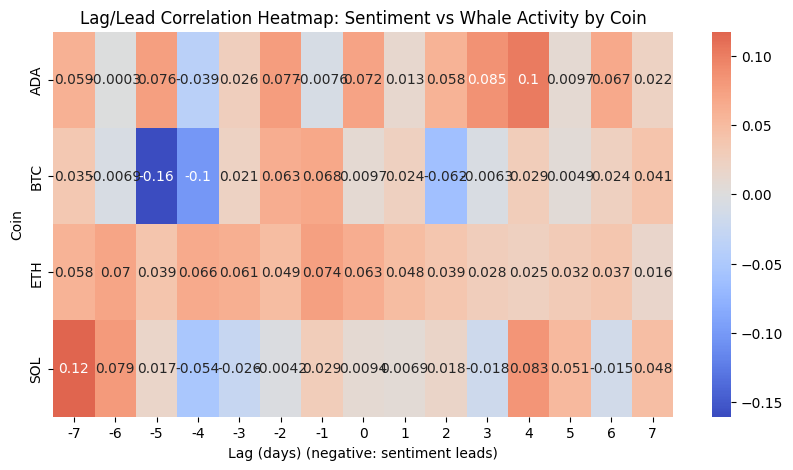

In [232]:
# Heatmap for all coins
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

max_lag = 7
lag_range = range(-max_lag, max_lag+1)
coin_cols = ['coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL']
coin_names = ['ADA', 'BTC', 'ETH', 'SOL']
heatmap_data = []

for coin_col in coin_cols:
    temp = []
    temp_df = df[df[coin_col] == 1]
    for lag in lag_range:
        corr = temp_df['whale_transaction_count'].corr(temp_df['sentiment'].shift(-lag))
        temp.append(corr)
    heatmap_data.append(temp)

plt.figure(figsize=(10,5))
sns.heatmap(np.array(heatmap_data), xticklabels=lag_range, yticklabels=coin_names, annot=True, cmap="coolwarm", center=0)
plt.title("Lag/Lead Correlation Heatmap: Sentiment vs Whale Activity by Coin")
plt.xlabel("Lag (days) (negative: sentiment leads)")
plt.ylabel("Coin")
plt.show()


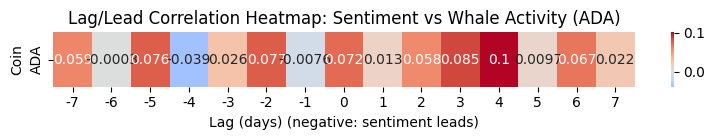

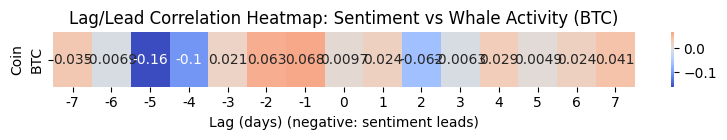

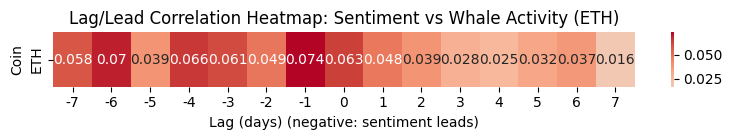

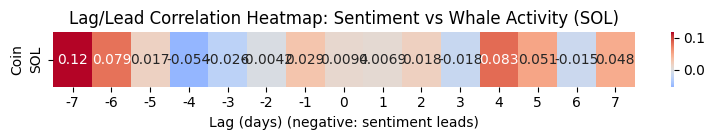

In [241]:
# Heat Map for each coin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

max_lag = 7
lag_range = range(-max_lag, max_lag+1)
coin_cols = ['coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL']
coin_names = ['ADA', 'BTC', 'ETH', 'SOL']

for coin_col, coin_name in zip(coin_cols, coin_names):
    temp_df = df[df[coin_col] == 1]
    corrs = []
    for lag in lag_range:
        corr = temp_df['whale_transaction_count'].corr(temp_df['sentiment'].shift(-lag))
        corrs.append(corr)
    # Plot heatmap (really just a row, but shown as a heatmap)
    plt.figure(figsize=(8, 1.5))
    sns.heatmap(
        np.array([corrs]), 
        xticklabels=lag_range, 
        yticklabels=[coin_name], 
        annot=True, 
        cmap="coolwarm", 
        center=0,
        cbar=True
    )
    plt.title(f"Lag/Lead Correlation Heatmap: Sentiment vs Whale Activity ({coin_name})")
    plt.xlabel("Lag (days) (negative: sentiment leads)")
    plt.ylabel("Coin")
    plt.tight_layout()
    plt.show()


In [ ]:
"""
The single-coin heatmaps reveal that the temporal relationship between sentiment and whale activity varies across cryptocurrencies. 
For ADA and SOL, sentiment changes appear to precede increases in whale activity after several days, suggesting that positive social mood
 may foreshadow large transactions. In contrast, BTC shows its strongest (negative) correlation when whale activity leads sentiment, 
 implying that large BTC transactions may be followed by a drop in retail mood. ETH displays a weak but consistently positive relationship, 
 with no clear leader. Overall, these findings suggest that the lag/lead dynamics are coin-specific, and that retail sentiment sometimes,
  but not always, provides early signals of future whale actions.
"""

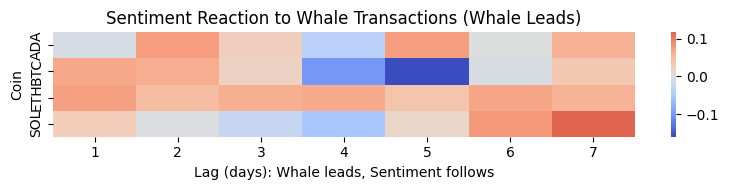

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

max_lag = 7
# Only look at POSITIVE lags: whale leads sentiment
lag_range = range(1, max_lag+1)
coin_cols = ['coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL']
coin_names = ['ADA', 'BTC', 'ETH', 'SOL']
heatmap_data = []

for coin_col in coin_cols:
    temp_df = df[df[coin_col] == 1]
    corrs = []
    for lag in lag_range:
        corr = temp_df['sentiment'].corr(temp_df['whale_transaction_count'].shift(-lag))
        corrs.append(corr)
    heatmap_data.append(corrs)

plt.figure(figsize=(8, 2))
sns.heatmap(
    np.array(heatmap_data), 
    xticklabels=lag_range, 
    yticklabels=coin_names, 
    annot=False, 
    cmap="coolwarm", 
    center=0,
    cbar=True
)
plt.title("Sentiment Reaction to Whale Transactions (Whale Leads)")
plt.xlabel("Lag (days): Whale leads, Sentiment follows")
plt.ylabel("Coin")
plt.tight_layout()
plt.show()


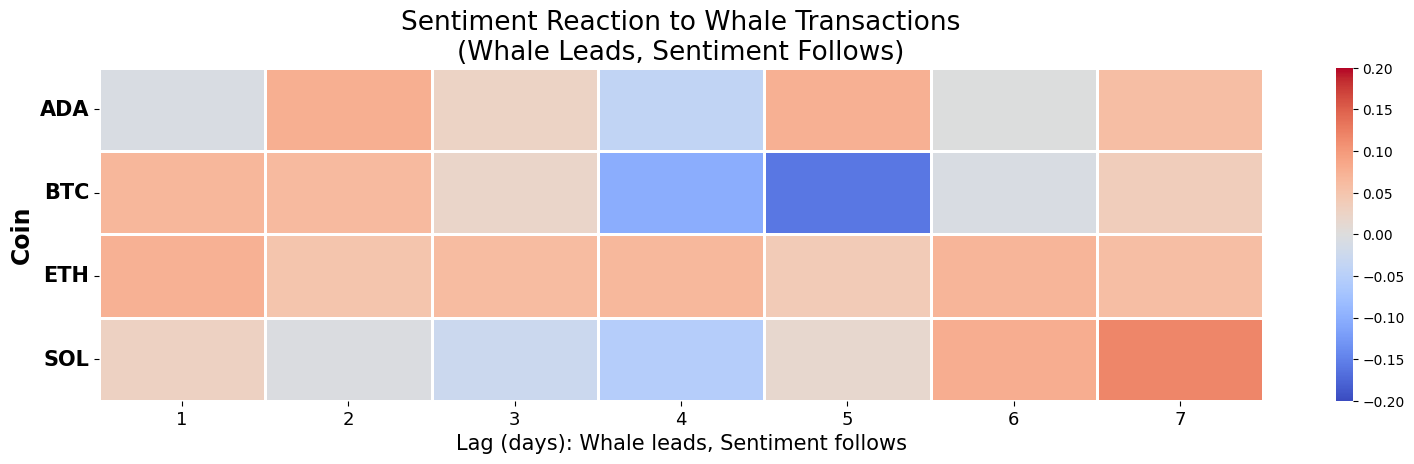

In [251]:
#Better view
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

max_lag = 7
lag_range = range(1, max_lag+1)
coin_cols = ['coin_ADA', 'coin_BTC', 'coin_ETH', 'coin_SOL']
coin_names = ['ADA', 'BTC', 'ETH', 'SOL']
heatmap_data = []

for coin_col in coin_cols:
    temp_df = df[df[coin_col] == 1]
    corrs = []
    for lag in lag_range:
        corr = temp_df['sentiment'].corr(temp_df['whale_transaction_count'].shift(-lag))
        corrs.append(corr)
    heatmap_data.append(corrs)

plt.figure(figsize=(16, 5))  # Bigger figure size for clarity

sns.heatmap(
    np.array(heatmap_data), 
    xticklabels=lag_range, 
    yticklabels=coin_names, 
    annot=False, 
    cmap="coolwarm", 
    center=0,
    cbar=True,
    linewidths=2,            # Lines between cells
    linecolor='white',       # White grid lines
    square=False,            # Each row can be larger than a column
    vmin=-0.2, vmax=0.2      # Make colors more visually balanced
)

plt.title("Sentiment Reaction to Whale Transactions\n(Whale Leads, Sentiment Follows)", fontsize=19)
plt.xlabel("Lag (days): Whale leads, Sentiment follows", fontsize=15)
plt.ylabel("Coin", fontsize=17, weight='bold')

plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=15, rotation=0, weight='bold')

plt.tight_layout(pad=2)
plt.savefig("sentiment_vs_whale_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()



In [ ]:
"""
Interpretation of Heatmap: Sentiment Reaction to Whale Transactions (Whale Leads, Sentiment Follows)
What this heatmap shows:
Each cell shows the correlation between sentiment and prior whale activity, at lags from 1 to 7 days. Only color is shown:

Redder cells: Stronger positive correlation (sentiment rises after whale activity).

Bluer cells: Stronger negative correlation (sentiment drops after whale activity).

Near white: No relationship.

Coin-by-coin analysis:
ADA:
Mostly mild positive or neutral correlations.

Slightly higher positive response at lag 2 and lag 5: Sentiment tends to increase about 2 or 5 days after whale activity spikes,
but the effect is not very strong.

BTC:
Mostly neutral or mild, except for a clear negative correlation at lag 5 (the bluest cell).

Interpretation: For BTC, a surge in whale activity is often followed by a decline in sentiment about 5 days later. The rest of the lags show weak or positive relationships.

ETH:
Consistently light orange: mild positive relationship at all lags.

Interpretation: Whale activity in ETH is followed by a gentle, persistent increase in sentiment over the next week, though the effect is small.

SOL:

The strongest positive response at lag 7 (darkest orange/red cell), and slightly positive at lags 6 and 5.

Interpretation: For SOL, large whale transactions tend to be followed by an increase in sentiment after about a week.

Overall summary for your report:
This heatmap illustrates that the reaction of retail sentiment to prior whale transactions is generally positive, 
especially for SOL and ETH, indicating that large whale activity can precede rising optimism in these coins. For ADA, 
the effect is weaker and less consistent, while BTC uniquely exhibits a strong negative sentiment response several days 
after whale spikes, suggesting possible concern or uncertainty among retail investors following large BTC movements. 
Overall, the lagged effect is coin-specific, with the most pronounced positive reaction for SOL at longer lags.

"""

In [248]:
plt.savefig("sentiment_vs_whale_heatmap.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [230]:
print(df.columns)


Index(['date', 'whale_transaction_count', 'total_volume', 'sentiment',
       'polarity', 'sentiment_lag1', 'polarity_lag1', 'polarity_lag1_enc',
       'whale_tx_lag1', 'whale_tx_roll3', 'coin_ADA', 'coin_BTC', 'coin_ETH',
       'coin_SOL'],
      dtype='object')


In [ ]:
# This will add columns: coin_ADA, coin_BTC, coin_ETH, coin_SOL
df = pd.get_dummies(df, columns=['coin'])
